TASK 1

In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

from helpers import *
from model import *
from generate import *

In [23]:
file, file_len = read_file("shakespeare.txt")

model = "gru"
n_epochs = 1000
print_every = 100
hidden_size = 50
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda = False


In [24]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename("shakespeare"))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)



Training for 1000 epochs...


 10%|█         | 100/1000 [01:08<10:23,  1.44it/s]

 8s (100 10%) 2.0724]
Whort me fold I of four.

MUCHIANGS INES:
O to as loed that thigh the and your gill have malow a sweav 



 20%|██        | 200/1000 [02:16<09:13,  1.45it/s]

 16s (200 20%) 1.8071]
What disting?

PETRUTTIS:
You hastengue me, groperforest
To he sow;
My all the propectuceland, this se 



 30%|███       | 300/1000 [03:24<08:04,  1.44it/s]

 24s (300 30%) 1.7073]
Whe sir.

CARDWAnd with to world wor: freas man the beseard upon the appiress stand of or thy him: of  



 40%|████      | 400/1000 [04:32<06:52,  1.46it/s]

 32s (400 40%) 1.6616]
Whone to do in soar,
Would he lies to have sir, it in bearth fither the beat, must you efrienditrus al 



 50%|█████     | 500/1000 [05:41<06:11,  1.35it/s]

 41s (500 50%) 1.6441]
Which the of him.
The gavion in of her lord:
For me you are, their bla, sorful not's a missice, daid,  



 60%|██████    | 600/1000 [06:51<04:43,  1.41it/s]

 51s (600 60%) 1.6076]
Which that is to now the trusce
I'll lord.

NORTHUMBERLAND:
A since like all as I have thou din's have 



 70%|███████   | 700/1000 [08:00<03:28,  1.44it/s]

 0s (700 70%) 1.6073]
What, I war! sere and he amers. Here in me a farther,
Dell the pain he is of herous no, peouse, my wor 



 80%|████████  | 800/1000 [09:08<02:20,  1.42it/s]

 8s (800 80%) 1.6052]
What my finest in my honour,
And all staid you a took the did for the cend.

First shall then hath muc 



 90%|█████████ | 900/1000 [10:16<01:08,  1.46it/s]

 16s (900 90%) 1.5762]
Whom not never did king: you and execution.

KING RICHARD III:
Yet and a have his time?

PERDITA:
Of y 



100%|██████████| 1000/1000 [11:25<00:00,  1.46it/s]

 25s (1000 100%) 1.5862]
Whar our strangelly.

KING RICHARD III:
I woe with make onage, the appy shall:
Unlies in the slays and 

Saving...
Saved as shakespeare.pt


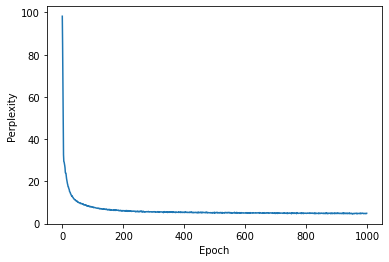

In [25]:

# Initialize models and start training


decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0
perplexities = []
try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        perplexities.append(math.exp(loss))

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=cuda), '\n')

    print("Saving...")
    save()
except KeyboardInterrupt:
    print("Saving before quit...")
    save()

plt.plot(perplexities)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

In [26]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

TASK 2

In [27]:
import string
import random

def randomString(len):
    s = ""
    for i in range(len):
        s = s + random.choice(string.printable)
    return s

In [67]:
dc = torch.load("shakespeare.pt")
prime_string = randomString(5)
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: ?h)Qc
?h)Qck, I am revouchay see, for laid,
Is bread against Rome me that betal stand viles of him,
When in thy


In [68]:
dc = torch.load("shakespeare.pt")
prime_string = randomString(5)
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string, temperature=0.8))

Prime string: f=r0X
f=r0X

DUKE VINCENTIO:
Give the kings think wery sister's give officers.

ISABELLA:
But the more fast as 


In [69]:
dc = torch.load("shakespeare.pt")
prime_string = randomString(5)
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: -/T+
-/T+kecked me proice, I way be never war us
Mad beseay young my broy degue the pard.

TRANIO:

POMPEY:
I


TASK 3

In [70]:
dc = torch.load("shakespeare.pt")
prime_string = "The"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: The
Thepherd with of man-now,
No courter from been and the royond; and a tone very know the day
Ib may stil


In [71]:
dc = torch.load("shakespeare.pt")
prime_string = "What is"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: What is
What is me plains with ared
When whese house I; 'leseon and more,
And proke's okest the now: the fear moria


In [72]:
dc = torch.load("shakespeare.pt")
prime_string = "Shall I give"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: Shall I give
Shall I giveth to the pounties to
scomplaintle renupe the beoul, and Kather and about? and it.

First Greest as 


In [73]:
dc = torch.load("shakespeare.pt")
prime_string = "X087hNYB BHN BYFVuhsdbs"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: X087hNYB BHN BYFVuhsdbs
X087hNYB BHN BYFVuhsdbs yets in that our hear the down
To brows made from me see the she weaven walk
Hath liberting the has


Task 4